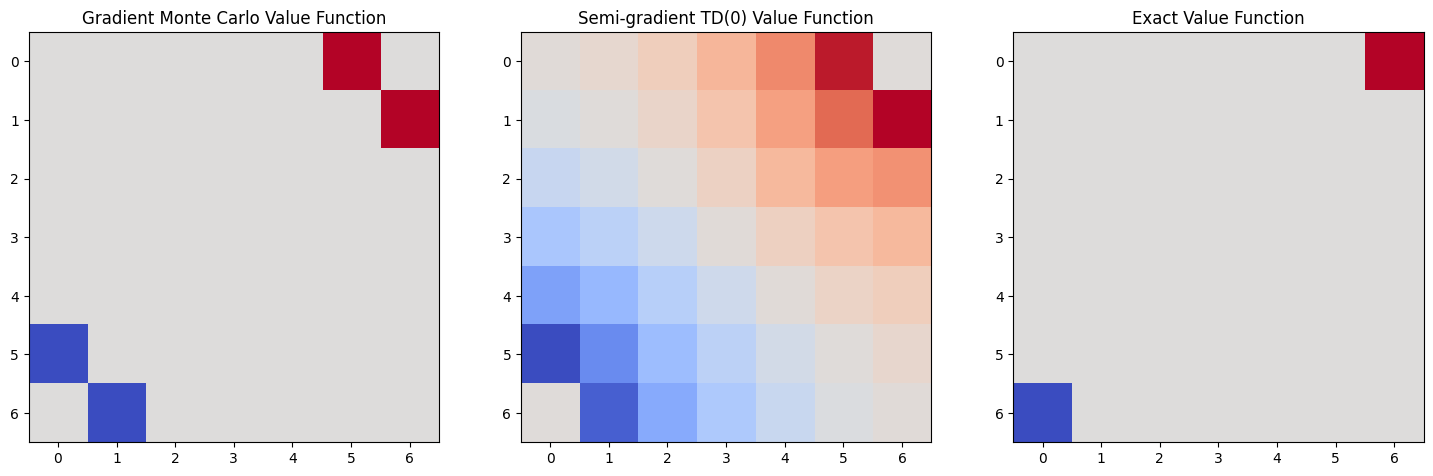

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define the grid world environment
class GridWorld:
    def __init__(self):
        self.size = 7
        self.start_state = (3, 3)
        self.terminal_states = {(6, 0): -1, (0, 6): 1}
        self.state = self.start_state
        self.actions = [0, 1, 2, 3]  # up, right, down, left

    def reset(self):
        self.state = self.start_state
        return self.state

    def step(self, action):
        row, col = self.state
        if action == 0:  # up
            row = max(row - 1, 0)
        elif action == 1:  # right
            col = min(col + 1, self.size - 1)
        elif action == 2:  # down
            row = min(row + 1, self.size - 1)
        elif action == 3:  # left
            col = max(col - 1, 0)

        self.state = (row, col)
        reward = self.terminal_states.get(self.state, 0)
        done = self.state in self.terminal_states
        return self.state, reward, done

# Gradient Monte Carlo Method
def gradient_monte_carlo(env, num_episodes, alpha=0.01, gamma=0.99):
    value_function = np.zeros((env.size, env.size))
    returns = {(i, j): [] for i in range(env.size) for j in range(env.size)}

    for _ in range(num_episodes):
        episode = []
        state = env.reset()
        while True:
            action = np.random.choice(env.actions)
            next_state, reward, done = env.step(action)
            episode.append((state, reward))
            state = next_state
            if done:
                break

        G = 0
        for state, reward in reversed(episode):
            G = gamma * G + reward
            if state not in [x[0] for x in episode[:-1]]:
                returns[state].append(G)
                value_function[state] += alpha * (G - value_function[state])

    return value_function

# Semi-gradient TD(0) Method
def semi_gradient_td0(env, num_episodes, alpha=0.01, gamma=0.99):
    value_function = np.zeros((env.size, env.size))

    for _ in range(num_episodes):
        state = env.reset()
        while True:
            action = np.random.choice(env.actions)
            next_state, reward, done = env.step(action)
            td_target = reward + gamma * value_function[next_state]
            value_function[state] += alpha * (td_target - value_function[state])
            state = next_state
            if done:
                break

    return value_function

# Compare the methods
env = GridWorld()
num_episodes = 5000

value_function_mc = gradient_monte_carlo(env, num_episodes)
value_function_td0 = semi_gradient_td0(env, num_episodes)

# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(value_function_mc, cmap='coolwarm', interpolation='none')
axes[0].set_title('Gradient Monte Carlo Value Function')
axes[1].imshow(value_function_td0, cmap='coolwarm', interpolation='none')
axes[1].set_title('Semi-gradient TD(0) Value Function')
exact_value_function = np.zeros((7, 7))
exact_value_function[6, 0] = -1
exact_value_function[0, 6] = 1
axes[2].imshow(exact_value_function, cmap='coolwarm', interpolation='none')
axes[2].set_title('Exact Value Function')
plt.show()


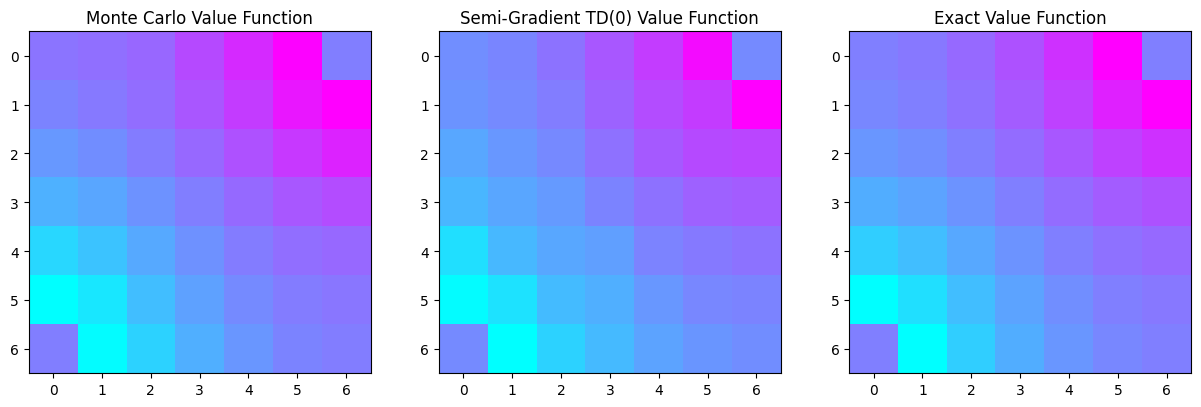

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
grid_size = 7
num_episodes = 10000
alpha = 0.1
gamma = 1.0

# Initialize the grid
grid = np.zeros((grid_size, grid_size))
start_state = (grid_size // 2, grid_size // 2)
terminal_states = {(grid_size - 1, 0): -1, (0, grid_size - 1): 1}

def is_terminal(state):
    return state in terminal_states

def get_reward(state):
    return terminal_states.get(state, 0)

def random_policy(state):
    return np.random.choice(['up', 'down', 'left', 'right'])

def next_state(state, action):
    i, j = state
    if action == 'up':
        return (max(i - 1, 0), j)
    elif action == 'down':
        return (min(i + 1, grid_size - 1), j)
    elif action == 'left':
        return (i, max(j - 1, 0))
    elif action == 'right':
        return (i, min(j + 1, grid_size - 1))
    return state

# Gradient Monte Carlo method
def gradient_monte_carlo():
    value_function = np.zeros((grid_size, grid_size))
    returns = {}

    for _ in range(num_episodes):
        state = start_state
        episode = []
        while not is_terminal(state):
            action = random_policy(state)
            next_state_ = next_state(state, action)
            reward = get_reward(next_state_)
            episode.append((state, reward))
            state = next_state_

        G = 0
        for (state, reward) in reversed(episode):
            G = gamma * G + reward
            if state not in [x[0] for x in episode[:episode.index((state, reward))]]:
                if state not in returns:
                    returns[state] = []
                returns[state].append(G)
                value_function[state] = np.mean(returns[state])

    return value_function

# Semi-Gradient TD(0) method with affine function approximation
def semi_gradient_td():
    value_function = np.zeros((grid_size, grid_size))
    w = np.zeros(grid_size * grid_size)

    def feature_vector(state):
        vec = np.zeros(grid_size * grid_size)
        vec[state[0] * grid_size + state[1]] = 1
        return vec

    for _ in range(num_episodes):
        state = start_state
        while not is_terminal(state):
            action = random_policy(state)
            next_state_ = next_state(state, action)
            reward = get_reward(next_state_)
            state_features = feature_vector(state)
            next_state_features = feature_vector(next_state_)

            delta = reward + gamma * np.dot(w, next_state_features) - np.dot(w, state_features)
            w += alpha * delta * state_features
            state = next_state_

    for i in range(grid_size):
        for j in range(grid_size):
            value_function[i, j] = np.dot(w, feature_vector((i, j)))

    return value_function

# Compute exact value function using Dynamic Programming (for comparison)
def exact_value_function():
    value_function = np.zeros((grid_size, grid_size))
    theta = 1e-10
    delta = float('inf')

    while delta > theta:
        delta = 0
        new_value_function = np.copy(value_function)
        for i in range(grid_size):
            for j in range(grid_size):
                state = (i, j)
                if is_terminal(state):
                    continue
                v = 0
                for action in ['up', 'down', 'left', 'right']:
                    next_state_ = next_state(state, action)
                    reward = get_reward(next_state_)
                    v += (0.25 * (reward + gamma * value_function[next_state_]))
                new_value_function[state] = v
                delta = max(delta, np.abs(v - value_function[state]))
        value_function = new_value_function

    return value_function

# Calculate value functions
mc_value_function = gradient_monte_carlo()
td_value_function = semi_gradient_td()
exact_value_function = exact_value_function()

# Plot the value functions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(mc_value_function, cmap='cool')
axes[0].set_title("Monte Carlo Value Function")
axes[1].imshow(td_value_function, cmap='cool')
axes[1].set_title("Semi-Gradient TD(0) Value Function")
axes[2].imshow(exact_value_function, cmap='cool')
axes[2].set_title("Exact Value Function")

plt.show()
